## Project 4: Advanced Lane Lines
### Author: Tri M. Cao
### Email: trimcao@gmail.com

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Part 1: Camera Calibration

#### Understand object points array

In [2]:
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
# :2 indicates the number of columns we consider
# in reshape method, -1 indicates one unknown dimesion
# (we only care about the other dimension)

#### Obtain objpoints and imgpoints arrays from calibration images

In [3]:
# set numbers of corner points in x and y coordinates.
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
print(images)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        # cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # write_name = 'corners_found'+str(idx)+'.jpg'
        # cv2.imwrite(write_name, img)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)

#cv2.destroyAllWindows()

['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


#### Distortion correction 

In [4]:
# obtain calibration parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   img.shape[0:2], None, None)

#### Test on a chessboard image

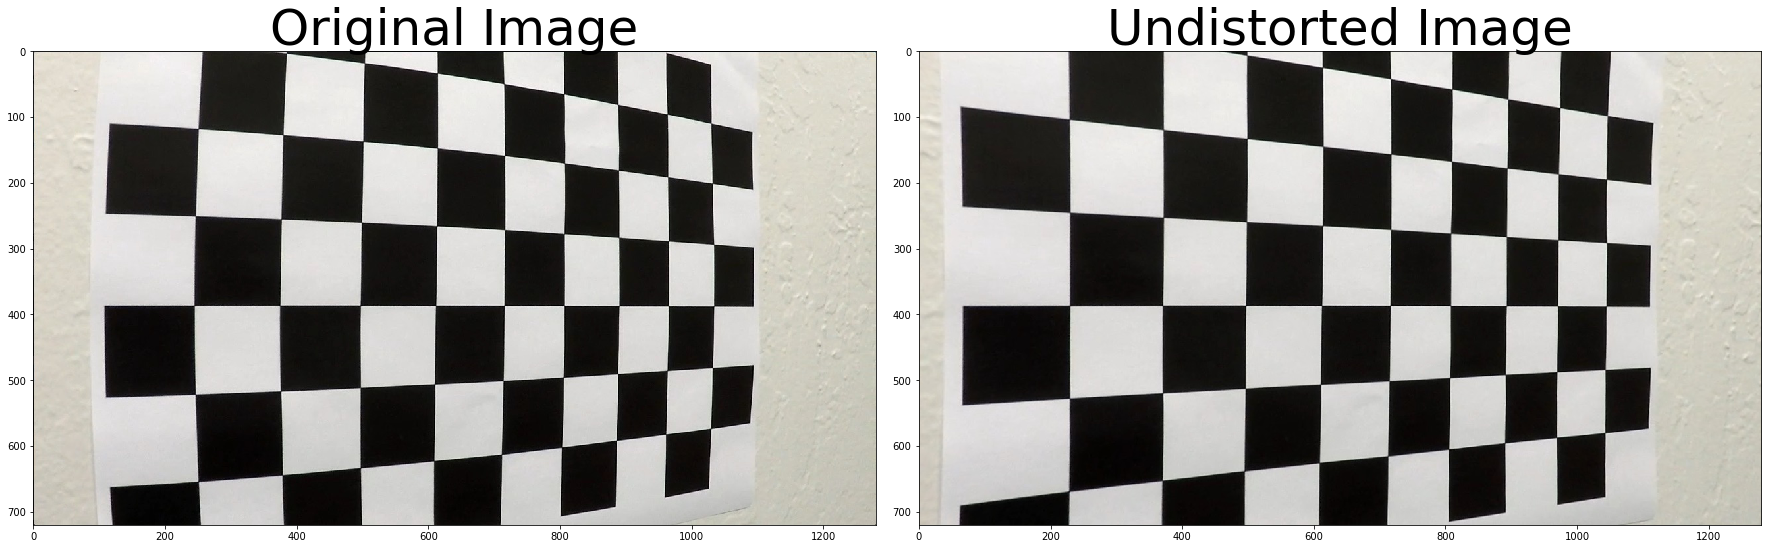

In [12]:
image = mpimg.imread('./camera_cal/test.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Camera Undistort Function

In [8]:
def cal_undistort(img, ret=ret, mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs):
    """
    Undistort an image from calibration.
    """
    # Use cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#### Example of undistorting an image

(-0.5, 1279.5, 719.5, -0.5)

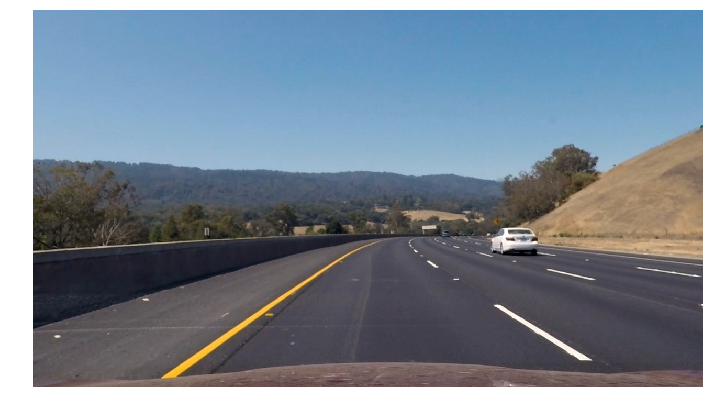

In [14]:
image = mpimg.imread('./test_images/test3.jpg')
undist = cal_undistort(image)
plt.rcParams["figure.figsize"] = (12, 7)
plt.imshow(undist)
plt.axis('off')

### Part 2: Color and Gradient Threshold

In [10]:
def thresholding(img, s_thresh=(180, 250), sx_thresh=(20, 100), h_thresh=(15,100), r_thresh=(200,255)):
    """
    Thresholding pipeline.
    """
    img = np.copy(img)
    # Use R-channel for white lane line
    r_channel = img[:,:,1]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    h_channel = hsv[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold L-channel (works just like R-channel)
    #l_binary = np.zeros_like(l_channel)
    #l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1    
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    color_binary = np.dstack(( h_binary, sxbinary, s_binary))
    # color_binary = np.dstack(( np.zeros_like(sxbinary), h_binary, np.zeros_like(s_binary)) )
    # combined binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1)] = 1
    # combined_binary[(s_binary == 1)] = 1
    return combined_binary


#### Example of color and gradient thresholding

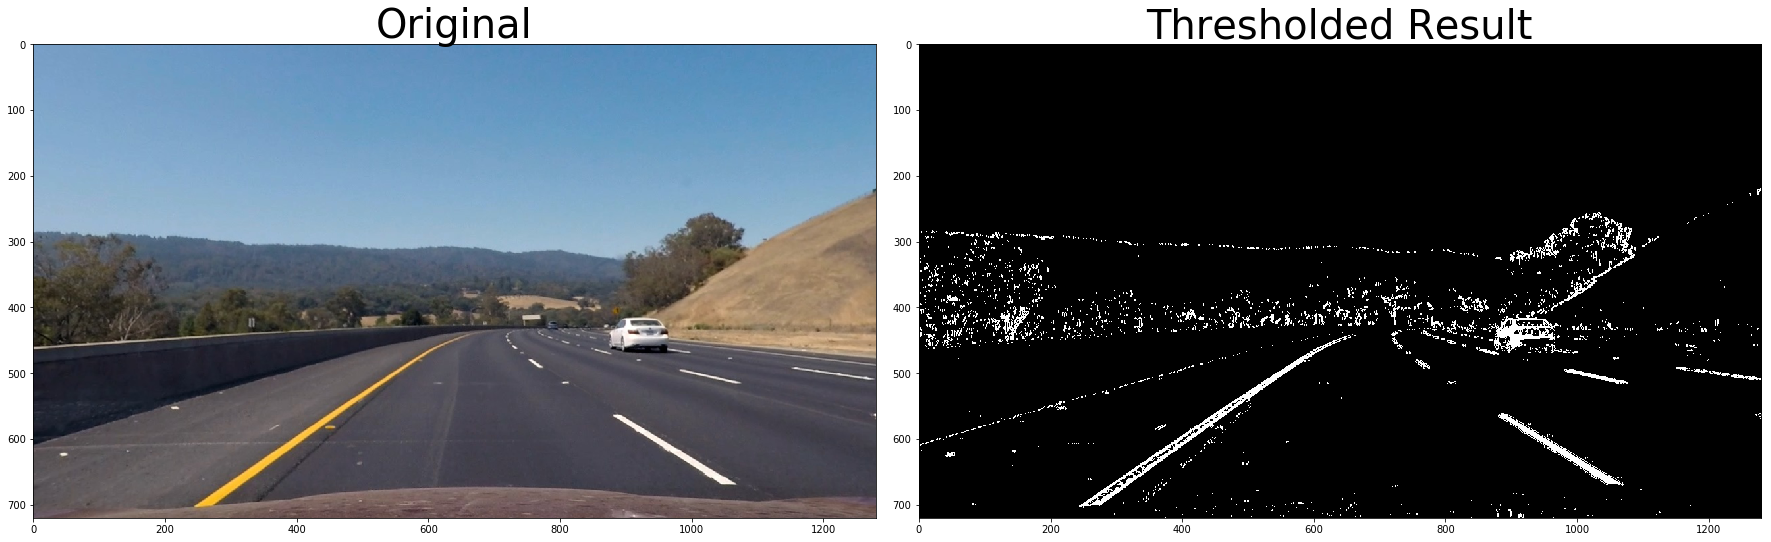

In [15]:
# test on an image
# image = mpimg.imread('./test_images/test3.jpg')
thresholded = thresholding(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original', fontsize=40)

ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Part 3: Perspective Transform

In [16]:
# Define the region of interest 
bottom_left = (190, 720)
upper_left = (590, 450)
upper_right = (690, 450)
bottom_right = (1130, 720)

# Define perspective transform destination (in pixels)
TRANSFORM_DST = [[200., 0.],
                 [900., 0.], 
                 [900., 720.], 
                 [200., 720.]]

In [17]:
def transform_pers(img, mtx, dist):
    """
    Transform perspective of an image.
    """
    img_size = (img.shape[1], img.shape[0])
    offset = 150 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # list the source points
    src = np.float32([upper_left,
                      upper_right,
                      bottom_right,
                      bottom_left,])
    # transform destination 
    dst = np.float32(TRANSFORM_DST)    
    # img_size = undist.shape
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)    
    return warped, M, Minv

#### Example of Perspective Transform

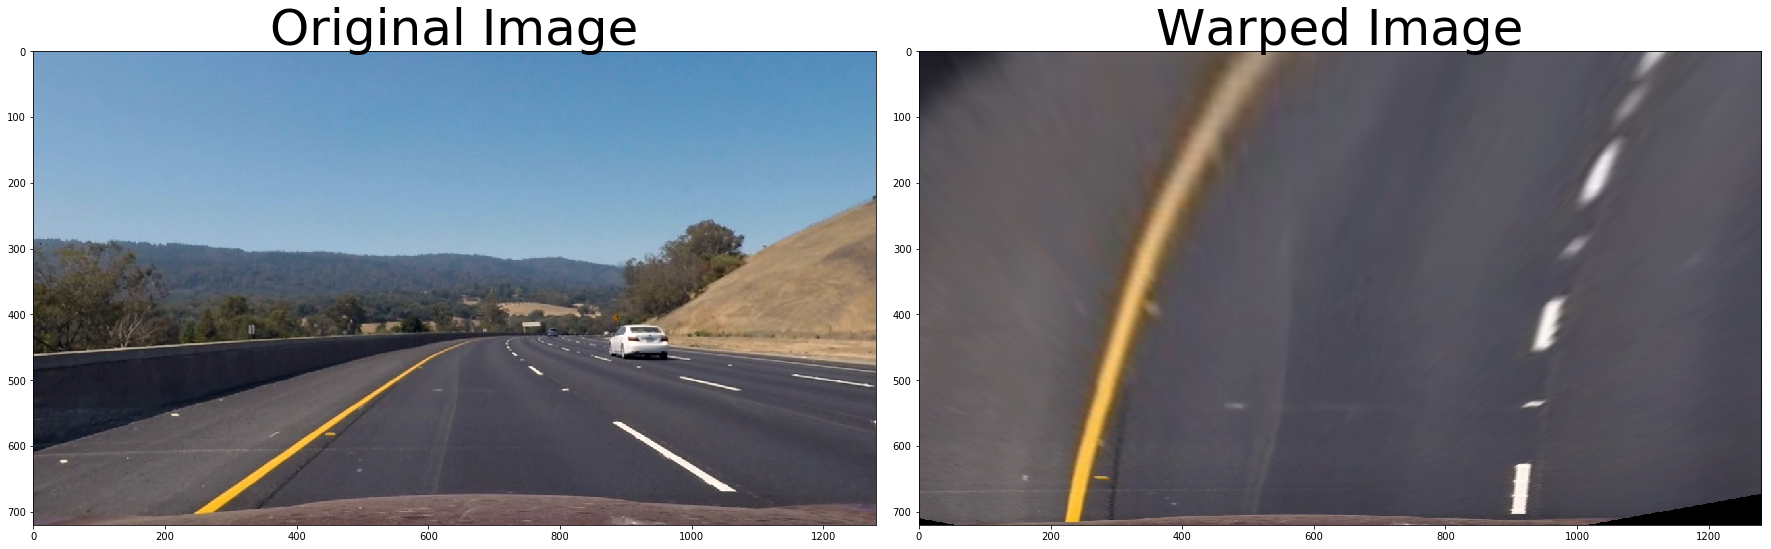

In [18]:
# image = mpimg.imread('./test_images/test3.jpg')
top_down, perspective_M, Minv = transform_pers(undist, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

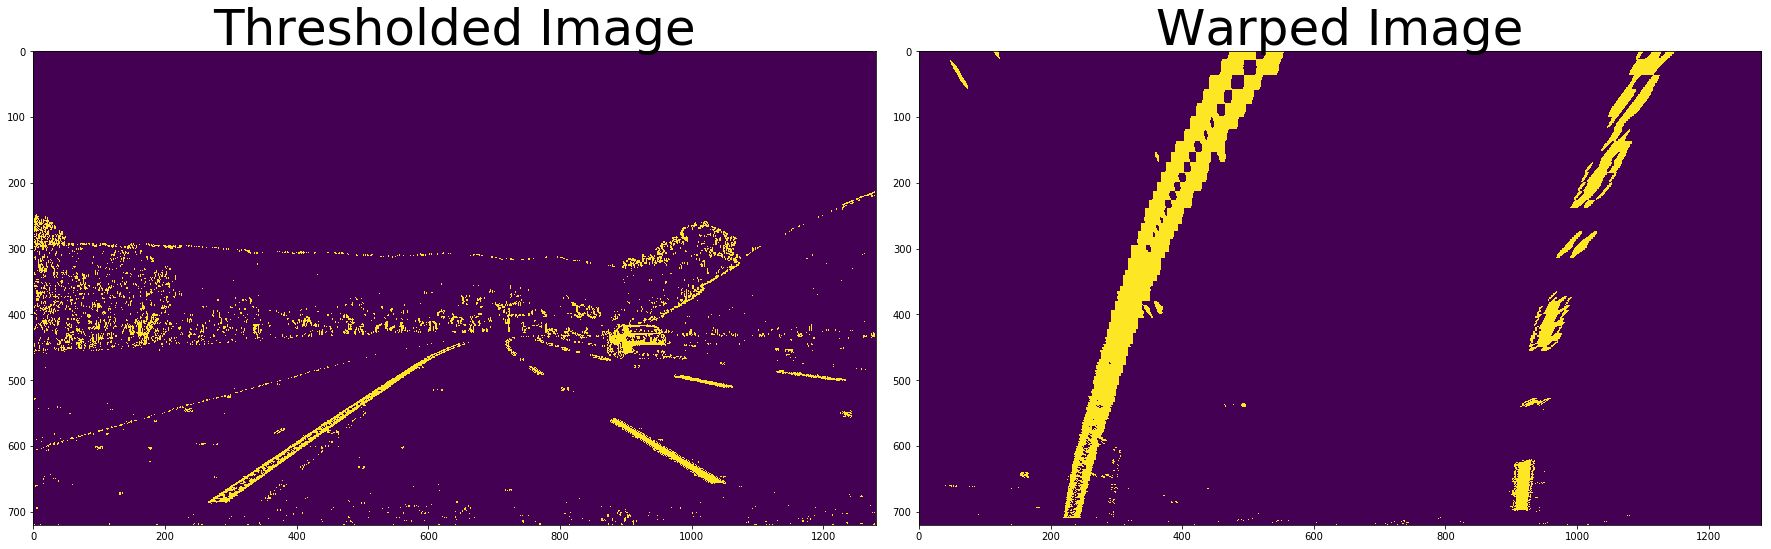

In [19]:
thresholded = thresholding(image)
top_down, perspective_M, Minv = transform_pers(thresholded, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded)
ax1.set_title('Thresholded Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Part 4: Finding Lines

In [20]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

#### Find lines using window search

In [21]:
def find_lines(binary_warped, visualize=False):
    """
    Find the lines in a warped binary image called "binary_warped".
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # print(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 50dr
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualize (optional)
    if visualize:
        lane_visualize(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds,
                       left_fit, right_fit)
    return left_fit, right_fit

#### Find lines using last frame's data

In [22]:
def fast_search(binary_warped, left_fit, right_fit):
    """
    Use last frame's data to find the lane lines.
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

#### Visualize the found lane lines

In [23]:
def lane_visualize(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds,
                   left_fit, right_fit, margin=100):
    """
    Visualize the detected lane lines (both left and right.
    """
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

#### Examples

(0.0, 1280.0, 720.0, 0.0)

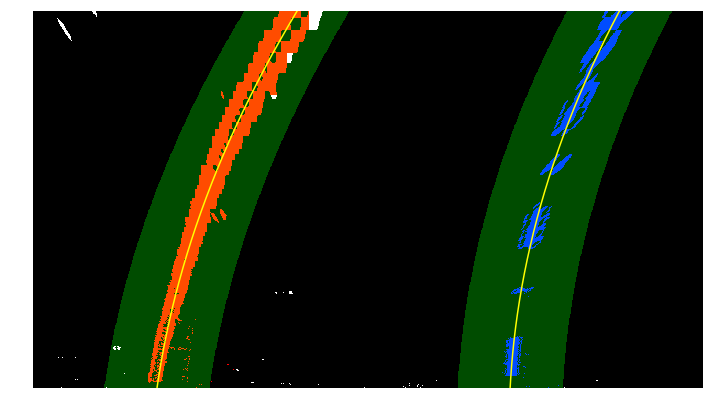

In [24]:
plt.rcParams["figure.figsize"] = (12, 7)
left_f, right_f = find_lines(top_down, visualize=True)
plt.axis('off')

### Part 5: Compute radius of curvature, and center lane offset

In [25]:
def curve(ploty, leftx, rightx, ym_per_pix=30/720, xm_per_pix=3.7/700):
    """
    Compute the curve.
    Output in meters.
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    """
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

In [26]:
def distance_from_center(img, left_fitx, right_fitx, ym_per_pix=30/720, xm_per_pix=3.7/700):
    """
    Compute the distance of the car from the lane center.
    """
    lane_center = (right_fitx[-1]+left_fitx[-1]) / 2
    car_center = img.shape[1] / 2
    dist = (car_center-lane_center)*xm_per_pix
    if dist > 0:
        return 'left', abs(dist)
    else:
        return 'right', abs(dist)

### Part 6: Draw lane onto the original image

In [27]:
def draw_lane(undist, warped, Minv, left_fit, right_fit):
    """
    Draw the lane on the original "image" using a "warped" binary image.
    undist: Undistorted image
    """
    # Create an image to draw the lines on
    # undist = cal_undistort(image)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # generate the x, y values of the line
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # find the curvature
    left_curve, right_curve = curve(ploty, left_fitx, right_fitx)
    ave_curve = round((left_curve+right_curve)/2, 2)
    # find the distance from lane center
    side, dist = distance_from_center(warped, left_fitx, right_fitx)
    side_text = 'Vehicle is ' + str(round(dist, 3)) + 'm ' + side + ' of center'
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (65, 205, 244))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # plt.imshow(result)
    # Draw curvature text
    result = cv2.putText(result, 'Radius of Curvature: '+str(ave_curve)+'m',(10,50), cv2.FONT_HERSHEY_SIMPLEX,
                         1.5, (255,255,255),2,cv2.LINE_AA)
    result = cv2.putText(result, side_text,(10,100), cv2.FONT_HERSHEY_SIMPLEX,
                         1.5, (255,255,255),2,cv2.LINE_AA)
    return result

#### Example of drawing lane

(-0.5, 1279.5, 719.5, -0.5)

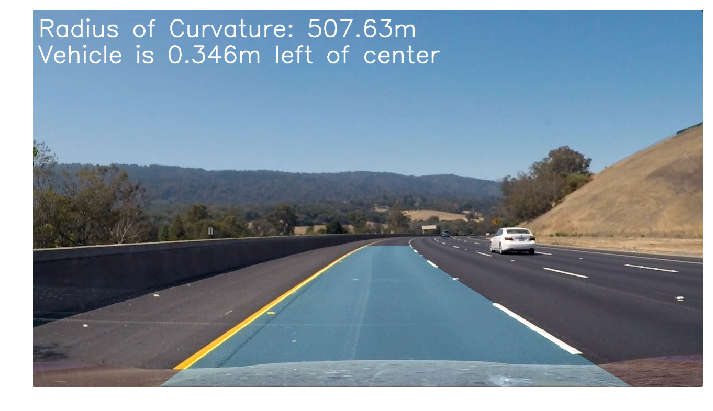

In [28]:
result = draw_lane(image, top_down, Minv, left_f, right_f)
plt.rcParams["figure.figsize"] = (12, 7)
plt.imshow(result)
plt.axis('off')

### Part 7: Completed Pipeline

In [29]:
def sanity_check(left_fit, right_fit):
    """
    Check if the left_fit and right_fit make sense.
    """
    diff = np.abs(left_fit - right_fit)
    return (diff[0] < 5e-4) & (diff[1] < 5e-1) & (6e+2 < diff[2] < 10e+2)

In [30]:
def process_line(line, cur_fit, ave):
    """
    Given the lines found by find_lines() method, compute
    average line fit (called best_fit).
    """
    if not line.detected:
        # if the line is not detected the last time
        line.detected = True
        line.current_fit = cur_fit
        # if the best_fit (average fit) has not been computed
        if line.best_fit is None:
            line.best_fit = cur_fit   
        else:
            line.best_fit = (1/ave) * (line.best_fit*(ave-1) + cur_fit)
    else:
        # if the line has been detected, just compute
        # the average fit
        line.current_fit = cur_fit
        line.best_fit = (1/ave) * (line.best_fit*(ave-1) + cur_fit)  
    return line, line.best_fit

In [31]:
def pipeline(image, ave=7):
    """
    Pipeline to find the lane.
    Used to process the video frames. 
    """
    # use global variables to keep track of the lines
    # over multiple frames
    global left_line, right_line
    global count_fast
    # Thresholding and warping the image
    undist = cal_undistort(image)
    binary_thresholded = thresholding(undist)
    warped, M, Minv = transform_pers(binary_thresholded, mtx, dist)
    # Find lines
    if not left_line.detected:
        cur_left_fit, cur_right_fit = find_lines(warped)
    else:
        count_fast += 1
        cur_left_fit, cur_right_fit = fast_search(warped, left_line.current_fit,
                                                  right_line.current_fit)
    # compare with the coefficients in left_line and right_line
    left_line, left_fit = process_line(left_line, cur_left_fit, ave)
    right_line, right_fit = process_line(right_line, cur_right_fit, ave)
    # If the lines found by fast_search do not pass the sanity check, 
    # just use the average fit line, will search again in the next frame
    # from scratch
    if not sanity_check(cur_left_fit, cur_right_fit):
        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
        left_line.detected = False
        right_line.detected = False
    # Draw the lane onto the original image
    result = draw_lane(undist, warped, Minv, left_fit, right_fit)  
    return result

### Part 8: Process the project video

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
# Initialize left line and right line objects
left_line = Line()
right_line = Line()
# Count how many times the fast_search() method is used
count_fast = 0
# Set the video output and input
output = 'output/project4.mp4'
# output = 'output/project4_text_short.mp4'
# origin_clip = VideoFileClip('./project_video.mp4').subclip(17,20)
origin_clip = VideoFileClip('./project_video.mp4')
drawn_clip = origin_clip.fl_image(pipeline)
%time drawn_clip.write_videofile(output, audio=False)
print(count_fast)

[MoviePy] >>>> Building video output/project4.mp4
[MoviePy] Writing video output/project4.mp4


100%|█████████▉| 1260/1261 [05:32<00:00,  3.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project4.mp4 

CPU times: user 5min 13s, sys: 1min 9s, total: 6min 22s
Wall time: 5min 33s
788
